# Circuits in Quantum Algorithms

Qiskit Circuit session, July 22nd, 2020

## What's a quantum algorithm?

Algorithms that run some part on a quantum computer. Here running on a quantum computer means running a circuit.

![](quantum_algo.png)

Today we'll focus on the circuit part, using Qiskit's circuit library.

![](quantum_algo_focus.png)

## Recap: The circuit library

The circuit library is a collection of valuable families of circuits. These circuits are are easily accessible, tested building blocks that work natively with the rest of Qiskit.

Interesting?
For algorithms, eduction and complexity analysis

Further material:
* `qiskit.circuit.library` 
* qiskit.org/documentation/apidoc/circuit_library.html
* Interactive overview: http://qisk.it/circuits
* See also previous session with Ali Javadi

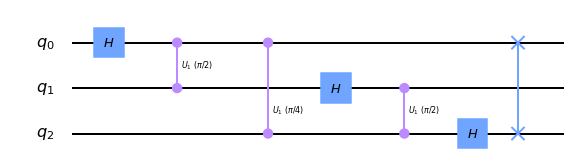

In [83]:
from qiskit.circuit.library import QFT

QFT(3).draw(output='mpl')

Seen they might have a couple of options.

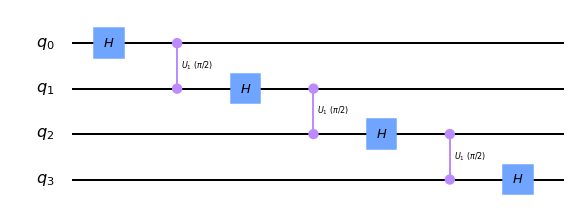

In [2]:
QFT(4, approximation_degree=2, do_swaps=False).draw(output='mpl')

Seen that they are normal circuits.

Non-local gates: 4
Operations: OrderedDict([('h', 3), ('cu1', 3), ('swap', 1)])


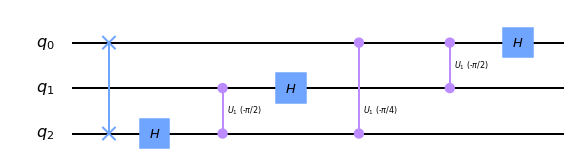

In [3]:
qft = QFT(3)
print('Non-local gates:', qft.num_nonlocal_gates())
print('Operations:', qft.count_ops())
qft.inverse().draw(output='mpl')

It's easy to stack them together. Remember the `compose` method:
```
QuantumCircuit.compose(circuit, qubits=None, inplace=False) 
```

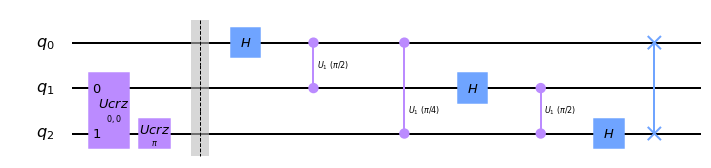

In [84]:
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import Diagonal

circuit = QuantumCircuit(3)
circuit.compose(Diagonal([1, 1, -1, -1]), [1, 2], inplace=True)
circuit.barrier()  # barrier for visualization purposes
circuit.compose(QFT(3), inplace=True)
circuit.draw(output='mpl')

## Overview

Let's have a look what circuits are in the circuit library.

![overview](overview.png)

## Workflow

How do we as users, researchers or developers want to use these circuits?

![](quantum_algo_circlib.png)

### Example: Variational Quantum Classifier

Supervised learning with quantum enhanced feature spaces, Havlicek et al. [arXiv:1804.11326](https://arxiv.org/abs/1804.11326)

![](quantum_algo_vqc.png)

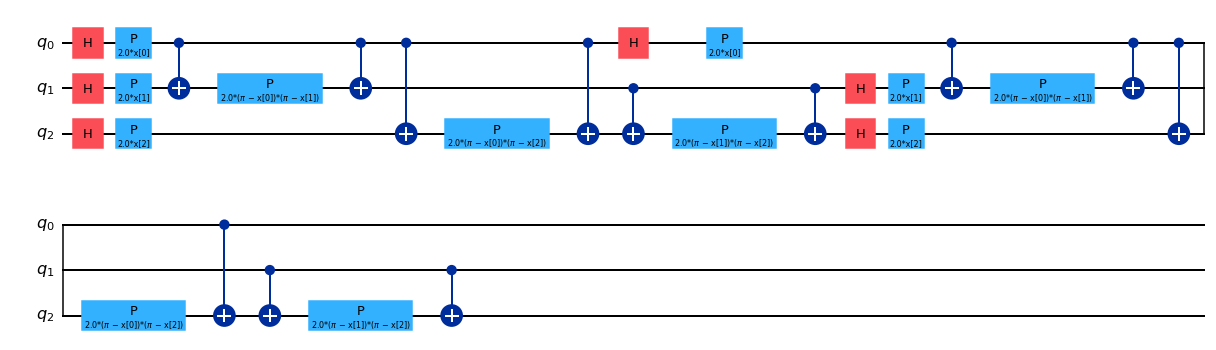

In [2]:
from qiskit.circuit.library.data_preparation import ZZFeatureMap  # can also drop .data_preparation

data_preparation = ZZFeatureMap(3)
data_preparation.draw(output='mpl', style='iqx')

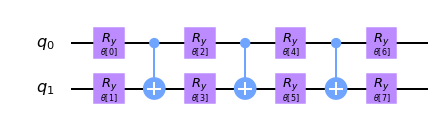

In [6]:
from qiskit.circuit.library.n_local import RealAmplitudes  # can also drop .n_local

classifier = RealAmplitudes(2)
classifier.draw(output='mpl')

In [7]:
from qiskit.aqua.algorithms import VQC
from qiskit.aqua.components.optimizers import SPSA
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from qiskit.ml.datasets import ad_hoc_data

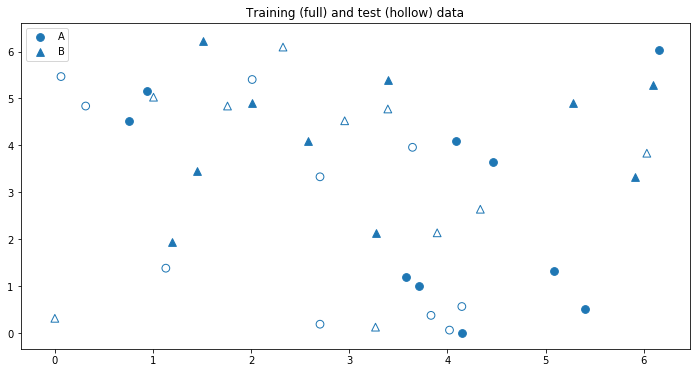

In [141]:
_, training_data, test_data, _ = ad_hoc_data(10, 10, 2, 0.2)

markers = ['o', '^']
plt.figure(figsize=(12,6))
plt.title('Training (full) and test (hollow) data')
for marker, (label, data) in zip(markers, training_data.items()):
    plt.scatter(data[:,0], data[:,1], color='tab:blue', label=label, s=60, marker=marker)
for marker, (label, data) in zip(markers, test_data.items()):
    plt.scatter(data[:,0], data[:,1], facecolor='', edgecolor='tab:blue', s=60, marker=marker)
plt.legend(loc='best');

In [142]:
optimizer = SPSA(maxiter=100)
vqc = VQC(optimizer, data_preparation, classifier, training_data)

In [143]:
from qiskit import Aer
from qiskit.aqua import QuantumInstance
backend = Aer.get_backend('qasm_simulator')

result = vqc.run(backend)
print('Loss:', result['training_loss'])

Loss: 0.3044436195870143


In [144]:
points_a = test_data['A']
points_b = test_data['B']
_, predicted_a = vqc.predict(points_a)
_, predicted_b = vqc.predict(points_b)

print('Score:', sum(predicted_a == 0) + sum(predicted_b == 1), '/', (len(predicted_a) + len(predicted_b)))

Score: 19 / 20


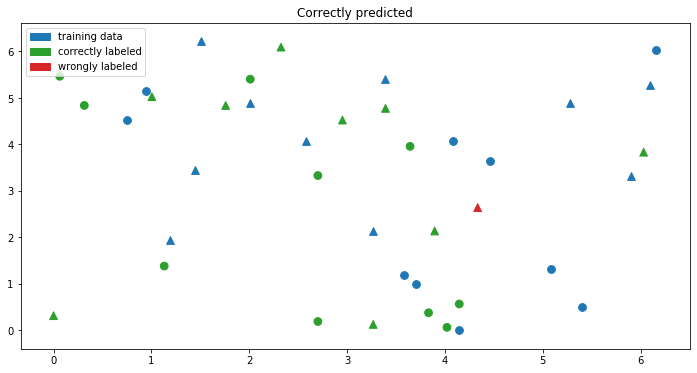

In [145]:
plt.figure(figsize=(12,6))
plt.title('Correctly predicted')
plt.scatter(points_a[:,0], points_a[:,1], s=60, marker='o',
            color=['tab:green' if label == 0 else 'tab:red' for label in predicted_a])
plt.scatter(points_b[:,0], points_b[:,1], s=60, marker='^',
            color=['tab:green' if label == 1 else 'tab:red' for label in predicted_b])
for marker, (label, data) in zip(markers, training_data.items()):
    plt.scatter(data[:,0], data[:,1], color='tab:blue', label=label, s=60, marker=marker)

train = mpatches.Patch(color='tab:blue', label='training data')
correct = mpatches.Patch(color='tab:green', label='correctly labeled')
wrong = mpatches.Patch(color='tab:red', label='wrongly labeled')
plt.legend(handles=[train, correct, wrong])

## Circuits in Algorithms

![](algo_overview.png)

Notebook link: github.com/Cryoris/notebooks

* QSVM, VQC: Supervised learning with quantum enhanced feature spaces, Havlicek et al. [arXiv:1804.11326](https://arxiv.org/abs/1804.11326)
* VQE: Moll
* Variational QTE: Ardle
* QGAN: Zoufal
* QBM: Zoufal
* QAOA: Farhi
* QSBO: Gacon
* QPE: Textbook
* QAE: , Woerner
* HHL: ..

## Building a quantum algorithm

Let's see how easy it is to build the quantum phase estimation (QPE) algorithm. Provided with $U$ and $|u\rangle$, we want to find $\varphi$.

$$
U|u\rangle = e^{2\pi i \varphi}|u\rangle
$$

This example:
$$
U = X \otimes X \cong 
\begin{pmatrix} 
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0 \\
0 & 1 & 0 & 0 \\
1 & 0 & 0 & 0
\end{pmatrix}
\text{ and }
|u\rangle = \frac{|00\rangle - |11\rangle}{\sqrt{2}} 
\cong
\frac{1}{\sqrt{2}} 
\begin{pmatrix}
1 \\ 0 \\ 0 \\ - 1
\end{pmatrix}
\text{ with }
e^{2\pi i\varphi} = - 1
$$

In [14]:
unitary = QuantumCircuit(2, name='U')
unitary.x(0)
unitary.x(1)

# (|00> - |11>) / sqrt(2)
bell1 = QuantumCircuit(2, name='|u>')
bell1.x(0)
bell1.h(0)
bell1.cx(0, 1)

In [15]:
from qiskit.quantum_info import Statevector

before = Statevector.from_instruction(bell1)
after = before.evolve(unitary)
print('Before applying the unitary:\n', before)
print('After:\n', after)
print('Factor of -1?\n', all(after.data * -1 == before.data))

Before applying the unitary:
 Statevector([ 0.70710678+0.j,  0.        +0.j,  0.        +0.j,
             -0.70710678+0.j],
            dims=(2, 2))
After:
 Statevector([-0.70710678+0.j,  0.        +0.j,  0.        +0.j,
              0.70710678+0.j],
            dims=(2, 2))
Factor of -1?
 True


The circuit we want to use is the following (see also [Nielsen]):

![](qpe_circ.png)

[Nielsen]: Quantum Computation and Quantum Information, Michael A. Nielsen & Isaac L. Chuang. [Online](http://mmrc.amss.cas.cn/tlb/201702/W020170224608149940643.pdf).

In [16]:
from qiskit.circuit import QuantumRegister, ClassicalRegister

num_eval_qubits = 3

qr_eval = QuantumRegister(num_eval_qubits, 'eval')
qr_unitary = QuantumRegister(unitary.num_qubits, 'state')
cr = ClassicalRegister(num_eval_qubits, 'bits')

circuit = QuantumCircuit(qr_eval, qr_unitary, cr)

# start with eigenstate
circuit.append(bell1, qr_unitary[:])

# hadamards
circuit.h(qr_eval)

# controlled powers
for i in range(num_eval_qubits):
    controlled_power = unitary.power(2 ** i).control()
    circuit.compose(controlled_power, qubits=[i] + qr_unitary[:], inplace=True)
    
# inverse qft 
iqft = QFT(num_eval_qubits, do_swaps=False).inverse()
circuit.append(iqft, qr_eval[:]) # could also use compose but append wraps it so it's nicer to read

circuit.measure(qr_eval, cr)

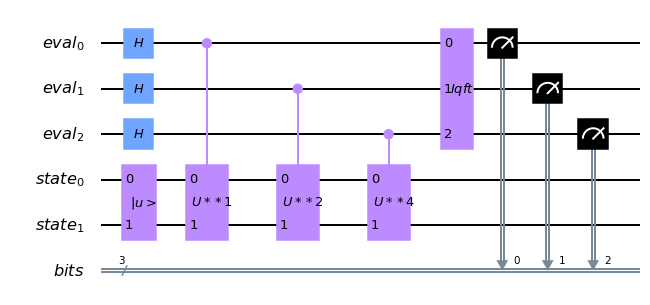

In [17]:
circuit.draw(output='mpl')

In [18]:
from qiskit import Aer, execute
backend = Aer.get_backend('qasm_simulator')
counts = execute(circuit, backend, shots=1024).result().get_counts()

In [19]:
counts

{'001': 1024}

Binary fraction: 
$$
    0.b_0 b_1 \dots = \frac{b_0}{2^1} + \frac{b_1}{2^2} + \cdots
$$
Means 
$$
    |001\rangle \rightarrow 0.100 = \frac{1}{2} + \frac{0}{4} + \frac{0}{8} = \frac{1}{2} = \varphi
$$

Thus we have the eigenvalue
$$
    \lambda = e^{2\pi i \varphi} = e^{\pi i} = -1
$$

Could also just do this with the `PhaseEstimation` circuit from the library:

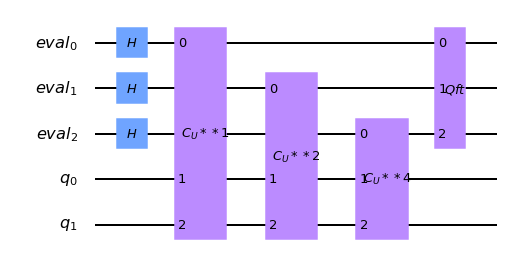

In [20]:
from qiskit.circuit.library import PhaseEstimation

pec = PhaseEstimation(3, unitary)
pec.draw(output='mpl')

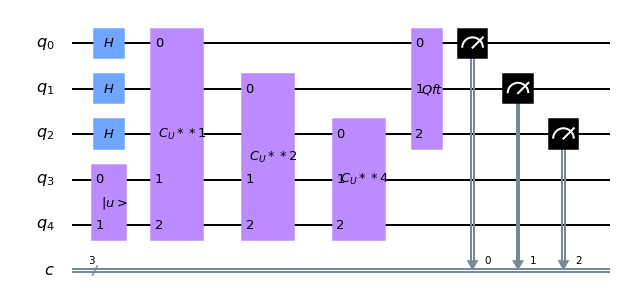

In [21]:
circuit = QuantumCircuit(5, 3)

# start with eigenstate
circuit.append(bell1, [3, 4])

# phase estimation
circuit.compose(PhaseEstimation(3, unitary), inplace=True)

# measure
circuit.measure([0, 1, 2], [0, 1, 2])

circuit.draw(output='mpl')

## Parameterized quantum circuits

### Max-cut problem

Goal: Find the largest possible cut in a given graph.

Further references: [Qiskit textbook](https://qiskit.org/textbook/ch-applications/qaoa.html) or [James Weaver's Medium article](https://medium.com/qiskit/the-variational-quantum-eigensolver-43f7718c2747) or [Moll].

[Moll]: Quantum optimization using variational algorithms
on near-term quantum devices, Moll et al. [arXiv:1710.01022](https://arxiv.org/pdf/1710.01022.pdf)

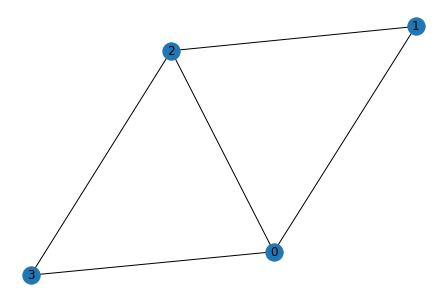

In [22]:
import networkx as nx

graph = nx.Graph()
graph.add_nodes_from([0, 1, 2, 3])
elist = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)]
graph.add_weighted_edges_from(elist)

nx.draw(graph, with_labels=True)

![](maxcut_line.png)

Maximum cut at labels 0101 (or 1010, since symmetric problem).

Objective function must be encoded in a Hamiltonian (see Ref. [Moll]):

In [24]:
from qiskit.aqua.operators import Z, I
ising = (I ^ I ^ Z ^ Z) + (I ^ Z ^ I ^ Z) + (Z ^ I ^ I ^ Z) + (I ^ Z ^ Z ^ I)

Which Ansatz? Ideally, we have full access to the subspace of possible solutions. Here, we e.g. don't need complex amplitudes.

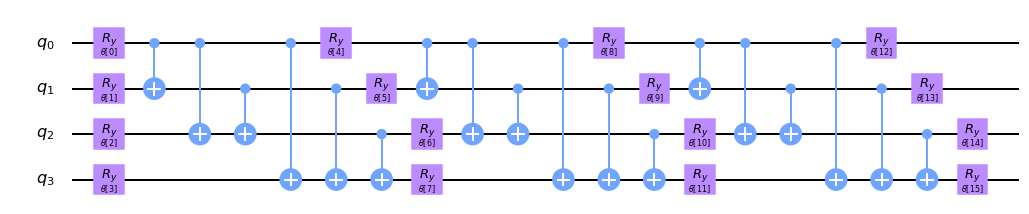

In [25]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=4)
ansatz.draw(output='mpl')

Why is it called `RealAmplitudes`? 

In [27]:
import numpy as np
from qiskit.quantum_info import Statevector

bound_ansatz = ansatz.assign_parameters(np.random.random(ansatz.num_parameters))
Statevector.from_instruction(bound_ansatz)

Statevector([0.35223618+0.j, 0.19504538+0.j, 0.3413613 +0.j,
             0.00225788+0.j, 0.07074963+0.j, 0.11899706+0.j,
             0.33085966+0.j, 0.24249931+0.j, 0.23170059+0.j,
             0.26273251+0.j, 0.41993687+0.j, 0.02834874+0.j,
             0.09823054+0.j, 0.10132007+0.j, 0.34313451+0.j,
             0.31047391+0.j],
            dims=(2, 2, 2, 2))

Let's run the algorithm!

In [52]:
from qiskit.aqua.algorithms import VQE
from qiskit.aqua.components.optimizers import SPSA

optimizer = SPSA()  # choosing Simultaneous Perturbation Stochastic Approximation optimizer
ansatz = RealAmplitudes(4, reps=4)  # ansatz on 4 qubits

vqe = VQE(ising, ansatz, optimizer)
result = vqe.run(Aer.get_backend('qasm_simulator'))
print('Minimal energy at:', result.eigenstate)

Minimal energy at: {'0010': 1, '0101': 1, '1010': 741, '1100': 202, '1110': 79}


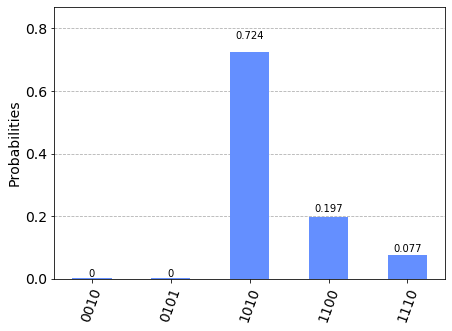

In [53]:
from qiskit.visualization import plot_histogram
plot_histogram(result.eigenstate)

We can also choose others, but they have more parameters and are more difficult to optimize since they have more parameters!

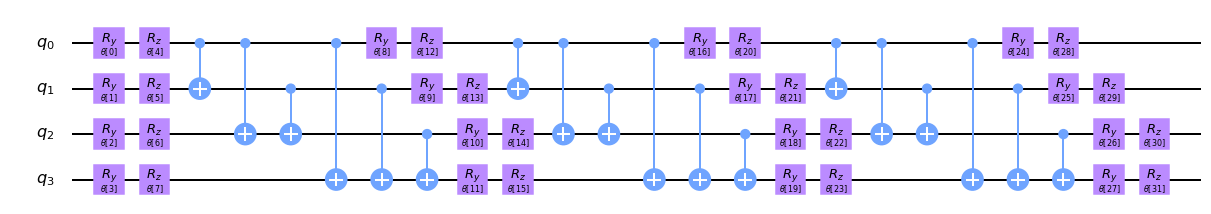

In [30]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(4)
ansatz.draw(output='mpl')

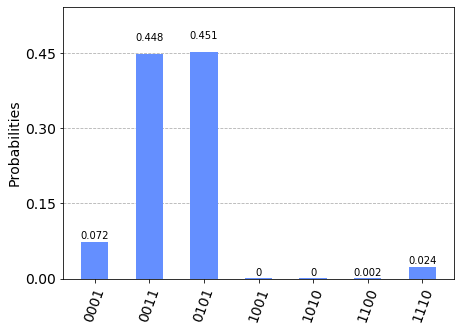

In [32]:
vqe = VQE(ising, ansatz, optimizer)
result = vqe.run(Aer.get_backend('qasm_simulator'))
plot_histogram(result.eigenstate)

### Creating your own Ansatz: The `TwoLocal` circuit

Template for hardware efficient, quantum-native circuits.

    TwoLocal(num_qubits, rotation_blocks, entanglement_blocks, reps, entanglement)

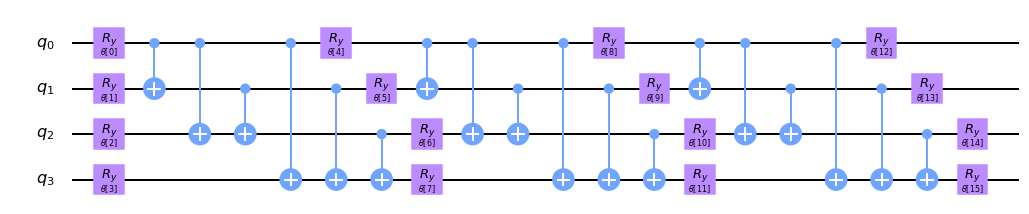

In [33]:
from qiskit.circuit.library import TwoLocal

two = TwoLocal(4, 'ry', 'cx')
two.draw(output='mpl')

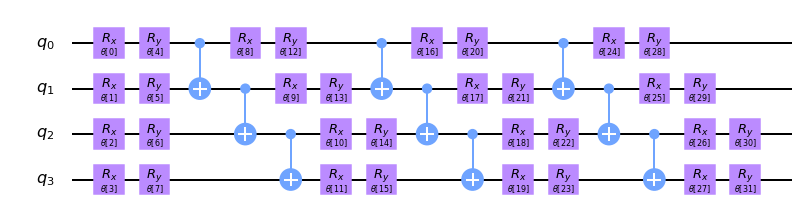

In [34]:
two = TwoLocal(4, ['rx', 'ry'], 'cx', entanglement='linear') # other options: 'full', 'circular', 'sca'
two.draw(output='mpl')

Convenient access to standard ansatz circuits, but complex custom circuits are easily constructed, e.g.:
* custom single- or two-qubit circuits
* custom entanglements
* different numbers of repetitions
* coupling of parameters
* etc.

$n$-local version: `qiskit.circuit.library.NLocal`.

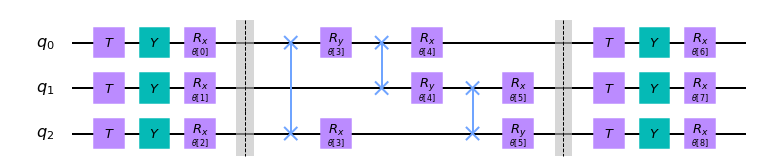

In [35]:
from qiskit.circuit import Parameter

p = Parameter('p')
ent = QuantumCircuit(2)
ent.swap(0, 1)
ent.rx(p, 0)
ent.ry(p, 1)

single = QuantumCircuit(1)
single.t(0)
single.y(0)

two = TwoLocal(3, [single, 'rx'], ent, entanglement='circular', reps=1, insert_barriers=True)
two.draw(output='mpl')

Which Ansatz works well? Active field of research! See e.g. [Sim].

Circuit 6 in [Sim] is proposed to work well for one repetition already.

![](circuit6.png)

[Sim]: Expressibility and entangling capability of parameterized quantum circuits for hybrid quantum-classical algorithms, Sim et al. [arXiv:1905.10876](https://arxiv.org/pdf/1905.10876.pdf)

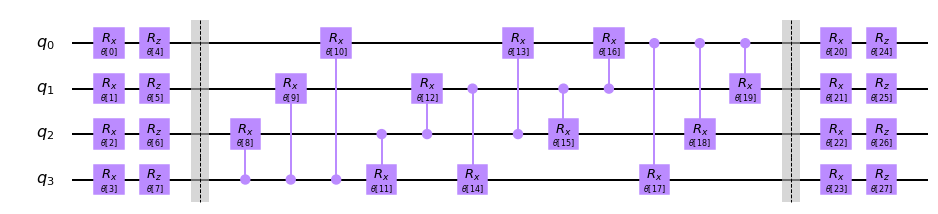

In [54]:
entanglement = [(3, 2), (3, 1), (3, 0),
                (2, 3), (2, 1), (2, 0),
                (1, 3), (1, 2), (1, 0),
                (0, 3), (0, 2), (0, 1)]
two = TwoLocal(4, ['rx', 'rz'], 'crx', entanglement=entanglement, reps=1, insert_barriers=True)
two.draw(output='mpl')

In [89]:
vqe = VQE(ising, two, optimizer)  # then run algorithm...

Any arbitrary circuit is supported as algorithm input.

In [38]:
from qiskit.circuit import QuantumCircuit, ParameterVector

ansatz = QuantumCircuit(4)

p = ParameterVector('p', 16)
p_iter = iter(p)

for i in range(4):
    ansatz.ry(next(p_iter), i)
ansatz.append(QFT(4, approximation_degree=1, do_swaps=False), [0, 1, 2, 3])
for i in range(4):
    ansatz.ry(next(p_iter), i)   
ansatz.append(QFT(4, approximation_degree=1, do_swaps=False).inverse(), [0, 1, 2, 3])
for i in range(4):
    ansatz.ry(next(p_iter), i)  

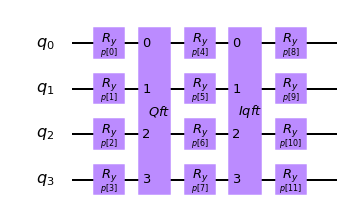

In [39]:
ansatz.draw(output='mpl')

In [40]:
vqe = VQE(ising, ansatz, optimizer)  # then run algorithm...

If it turns out to be good, add it to the library! 

### Summary

* Choose the right Ansatz for your application
* Qiskit's algorithms run on any custom circuit
* Circuit library offers a set of standard ansatz circuits (like `RealAmplitudes`) and tools to build new ones (`TwoLocal`)

## Chemistry applications

The ansatz tries to approximate the ground state of a molecule. `RealAmplitudes` from before is not the right, we want complex amplitudes!

In [56]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(2)
bound_ansatz = ansatz.assign_parameters(np.random.random(ansatz.num_parameters))
Statevector.from_instruction(bound_ansatz)

Statevector([ 0.77658928-0.18547926j, -0.02534895+0.21396543j,
              0.25962842+0.22161376j,  0.06110877+0.4425256j ],
            dims=(2, 2))

In [42]:
import os
os.environ['QISKIT_IN_PARALLEL'] = 'TRUE'

In [43]:
# run H2 molecule
from qiskit.aqua.operators import I, Z, X
from qiskit.aqua.components.optimizers import L_BFGS_B

h2_op = -1.052373245772859 * (I ^ I) + 0.39793742484318045 * (I ^ Z) \
        - 0.39793742484318045 * (Z ^ I) - 0.01128010425623538 * (Z ^ Z) \
        + 0.18093119978423156 * (X ^ X)
h2_energy = -1.85727503

optimizer = L_BFGS_B()  # Broyden–Fletcher–Goldfarb–Shanno

backend = Aer.get_backend('qasm_simulator')

vqe = VQE(h2_op, ansatz, optimizer)
res = vqe.run(backend)
res.eigenvalue.real

-1.5598794124645186

### Another approach: Classically motivated

In chemistry, the UCCSD(T) method is considered the "gold" standard to compute the ground state energy.
This also uses the variational principle with a certain wavefunction ansatz. 
We can also use this wavefunction here! 

[Barkoutsos]: Quantum algorithms for electronic structure calculations: particle/hole Hamiltonian
and optimized wavefunction expansions, Barkoutsos et al. [arXiv:1805.04340](https://arxiv.org/pdf/1805.04340.pdf)

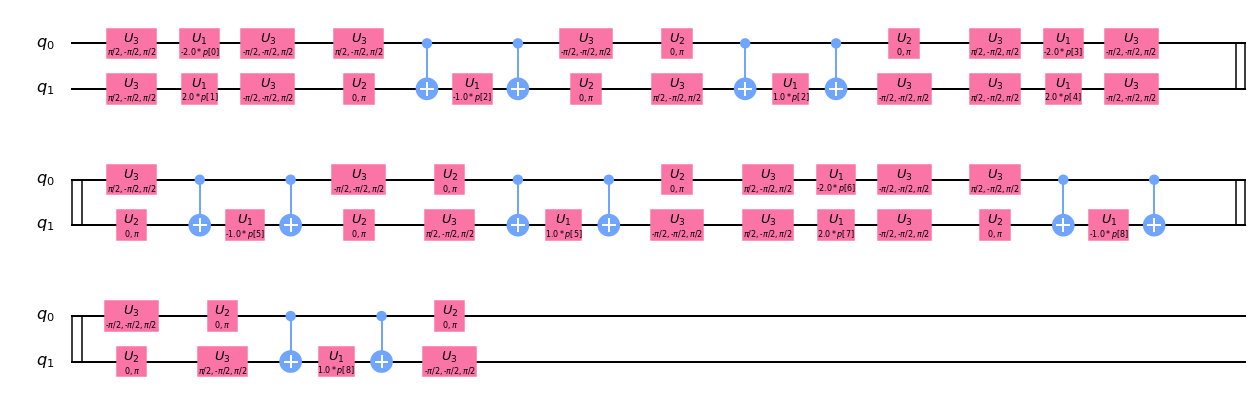

In [57]:
from qiskit.chemistry.components.variational_forms import UCCSD

ucc = UCCSD(4, 2, reps=3)
p = ParameterVector('p', ucc.num_parameters)
ansatz = ucc.construct_circuit(p).decompose()
ansatz.draw(output='mpl')

In [49]:
vqe = VQE(h2_op, ansatz, optimizer)
res = vqe.run(backend)
res.eigenvalue.real

-1.869270947305635

This worked well for this small system... what about larger systems? 

In [63]:
from qiskit.chemistry.drivers import PySCFDriver
from qiskit.chemistry import FermionicOperator
from qiskit.aqua.operators import Z2Symmetries

H2 = 'H 0.0 0.0 0.0; H 0.0 0.0 0.735'  # molecular coordinates in Angstrom
LiH = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.3'

def define_chemistry_problem(atom, basis, reduction=True):
    molecule = PySCFDriver(atom=atom, basis=basis).run()
    num_particles = molecule.num_alpha + molecule.num_beta
    num_orbitals = 2 * molecule.num_orbitals

    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    if reduction:
        qubitOp = ferOp.mapping(map_type='parity')
        qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    else:
        qubitOp = ferOp.mapping(map_type='jordan_wigner')

    return qubitOp.to_opflow(), num_particles, num_orbitals

In [64]:
qubitOp, num_particles, num_orbitals = define_chemistry_problem(H2, 'sto3g')
print(qubitOp)

SummedOp(
[-1.052373245772859 * II,
0.39793742484318007 * IZ,
-0.39793742484318007 * ZI,
-0.01128010425623538 * ZZ,
0.18093119978423136 * XX])


In [65]:
num_orbitals, num_particles

(4, 2)

In [66]:
qubitOp, num_particles, num_orbitals = define_chemistry_problem(LiH, 'sto3g')
print(qubitOp)

SummedOp(
[-5.259038246818582 * IIIIIIIIII,
1.0235687911585036 * IIIIIIIIIZ,
-0.01771856623628656 * IIIIIIIIZX,
0.01771856623628656 * IIIIIIIIIX,
-0.02654806113115581 * IIIIIIIZXX,
-0.02654806113115581 * IIIIIIIIYY,
-0.004686977340277227 * IIIIIXXXXX,
-0.004686977340277227 * IIIIIYXXXY,
-0.1060833226130983 * IIIIIIIIZZ,
0.008011661921423425 * IIIIIIIZXZ,
-0.008011661921423425 * IIIIIIIIXI,
-0.005696482431937478 * IIIIIXXXXZ,
-0.005696482431937478 * IIIIIYXXYI,
-0.19442319698823987 * IIIIIIIZZI,
-0.014333639794327236 * IIIIIXXXZI,
-0.014333639794327236 * IIIIIYXYII,
-0.22447370517677553 * IIIIIIZZII,
-0.22447370517677542 * IIIIIZZIII,
-0.41689839336782997 * IIIIIZIIII,
1.0235687911585032 * IIIIZIIIII,
-0.017718566236286547 * IIIZXIIIII,
0.017718566236286547 * IIIIXIIIII,
-0.026548061131155848 * IIZXXIIIII,
-0.026548061131155848 * IIIYYIIIII,
-0.004686977340277227 * XXXXXIIIII,
-0.004686977340277227 * YXXXYIIIII,
-0.10608332261309833 * IIIZZIIIII,
0.008011661921423434 * IIZXZIIIII,
-0.00

In [90]:
num_orbitals, num_particles

(12, 4)

In [82]:
ucc = UCCSD(num_orbitals, num_particles)
p = ParameterVector('p', ucc.num_parameters)
ansatz = ucc.construct_circuit(p).decompose()

print('#Qubits:', ansatz.num_qubits, 'Depth:', ansatz.depth(), '#Params:', ansatz.num_parameters)

#Qubits: 10 Depth: 8467 #Params: 92


## Compromise?

In the Jordan-Wigner mapping, a qubit state of $|1\rangle$ can be associated with an existing particle. Since the total number of particles should be conserved, the Ansatz wavefunction should conserve the number of $|1\rangle$ states, e.g.:

$$
\begin{matrix}
    & \mid & |00\rangle & |10\rangle & |01\rangle & |11\rangle \\
    \hline
    \langle 00| & \mid & 1 & 0 & 0 & 0 \\
    \langle 10|& \mid & 0 & \cos(\theta/2) & -i\sin(\theta/2) & 0 \\
    \langle 01|& \mid & 0 & -i\sin(\theta/2) & \cos(\theta/2) & 0 \\
    \langle 11|& \mid & 0 & 0 & 0 & 1
\end{matrix}
$$

The `ExcitationPreserving` circuit does that.


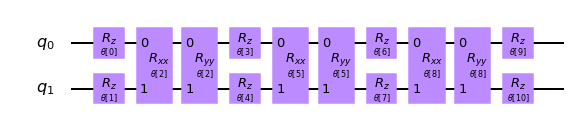

In [98]:
from qiskit.circuit.library import ExcitationPreserving

ansatz = ExcitationPreserving(2)
ansatz.draw(output='mpl')

In [80]:
qubitOp, num_particles, num_orbitals = define_chemistry_problem(LiH, 'sto3g', reduction=False)
ansatz = ExcitationPreserving(qubitOp.num_qubits)
print('#Qubits:', ansatz.num_qubits, 'Depth:', ansatz.depth(), '#Params:', ansatz.num_parameters)

#Qubits: 12 Depth: 94 #Params: 246


# Contributing!

* Add new circuits
    * more arithmetic circuits
    * more basis changes
    * circuits that you'd like to share! 
    * ?
* More tests
    * Find efficient ways to test circuits
* Optimized versions of circuits
* More options for circuits

# Summary

1. Circuits are algorithm primitives
2. The circuit library...
    1. offers a building blocks for algorithms
    2. has a selection for different algorithm inputs
    3. is extensible!

# Supplementary material

## QAE

Estimate $a$ in

$$
\mathcal{A}|0\rangle = \sqrt{1 - a}|\Psi_0\rangle + \sqrt{a}|\Psi_1\rangle 
$$

If we set $a$ to $\mathbb{E}[f(X)]$ we can get a quadratic speedup compared to Monte-Carlo simulations [Woerner]!
Works by creating a circuit

$$
\mathcal{A}|0\rangle_{n+1} = \sum_{i=0}^{N - 1} \sqrt{p_{x_i} (1 - f(x_i))} |x\rangle_n |0\rangle + 
\sum_{i=0}^{N - 1} \sqrt{p_{x_i} f(x_i)} |x\rangle_n |1\rangle
$$

Here

$$
f_y(x) = \sin^2(2x - y)
$$

In [109]:
y = 0.5

In [110]:
from qiskit.circuit.library import LinearPauliRotations

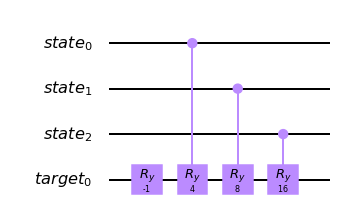

In [111]:
LinearPauliRotations(3, slope=2*2, offset=-2*y).draw(output='mpl')

In [112]:
f = LinearPauliRotations(2, slope=2*2, offset=2*1)
equal_superpos = QuantumCircuit(3)
equal_superpos.h([0, 1])

sv = Statevector.from_label('000')
sv = sv.evolve(equal_superpos)
sv = sv.evolve(f)
sv.probabilities(qargs=[2])

array([0.48021114, 0.51978886])

In [115]:
num_probability_qubits = 3
y = 0.5
M = 2 ** num_probability_qubits
1 / M * sum((i / (M - 1) - y) ** 2 for i in range(M))

0.10714285714285714

In [116]:
num_probability_qubits = 3
uniform_distribution = QuantumCircuit(num_probability_qubits)
uniform_distribution.h(list(range(num_probability_qubits)))

slope = 2 / (2 ** num_probability_qubits - 1)
offset = -2 * y
linear_function = LinearPauliRotations(num_probability_qubits, slope, offset)

unitary = QuantumCircuit(num_probability_qubits + 1)
unitary.compose(uniform_distribution, qubits=list(range(num_probability_qubits)), inplace=True)
unitary.compose(linear_function, inplace=True)

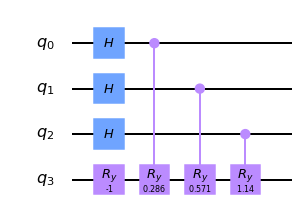

In [117]:
unitary.draw(output='mpl')

###  Building Q

In [118]:
S_psi_0 = QuantumCircuit(4)
S_psi_0.x(3)
S_psi_0.z(3)
S_psi_0.x(3)

In [119]:
from qiskit.circuit.library import ZGate

S_0 = QuantumCircuit(4)
S_0.x([0, 1, 2, 3])
S_0.append(ZGate().control(3), [0, 1, 2, 3])
S_0.x([0, 1, 2, 3])

In [120]:
Q = QuantumCircuit(4)
Q.compose(S_psi_0, inplace=True)
Q.barrier()
Q.compose(unitary.inverse(), inplace=True)
Q.barrier()
Q.compose(S_0, inplace=True)
Q.barrier()
Q.compose(unitary, inplace=True)

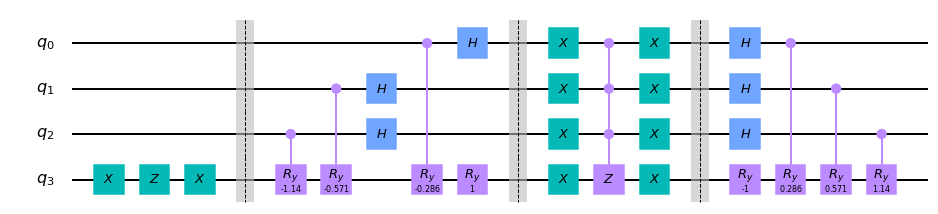

In [121]:
Q.draw(output='mpl')

In [122]:
Q = QuantumCircuit(4)
Q.compose(S_psi_0, inplace=True)
Q.compose(unitary.inverse(), inplace=True)
Q.compose(S_0, inplace=True)
Q.compose(unitary, inplace=True)

In [123]:
num_eval_qubits = 3
qae = QuantumCircuit(num_eval_qubits + num_probability_qubits + 1, num_eval_qubits)
qae.compose(unitary, qubits=[3, 4, 5, 6], inplace=True)
qae.compose(PhaseEstimation(3, Q), inplace=True)
qae.measure([0, 1, 2], [0, 1, 2])

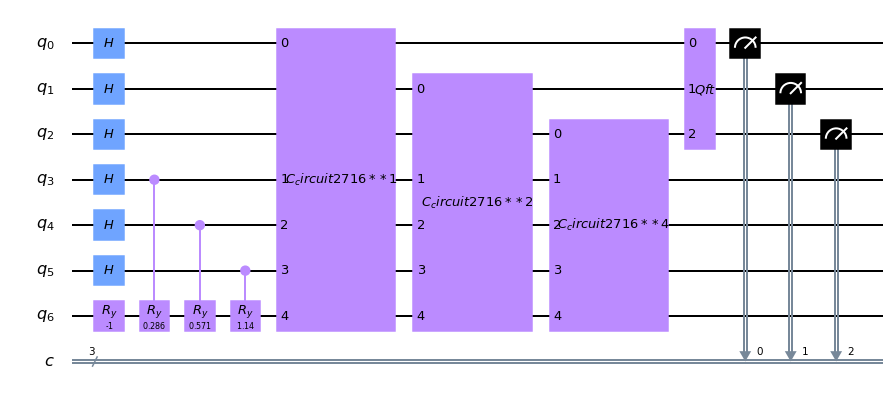

In [124]:
qae.draw(output='mpl')

In [125]:
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram
import numpy as np

In [126]:
backend = Aer.get_backend('qasm_simulator')
counts = execute(qae, backend).result().get_counts()
print(counts)

{'000': 44, '001': 6, '010': 14, '011': 12, '100': 456, '101': 8, '110': 5, '111': 479}


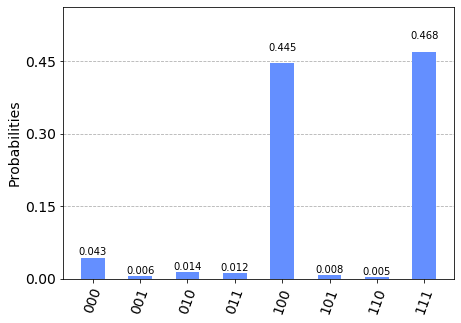

In [127]:
plot_histogram(counts)

Accumulate states with same outcome and get most likely

In [135]:
accumulated = {}
for state, count in counts.items():
    y = int(state[::-1], 2)
    if y > M / 2:
        y = M - y
    accumulated[y] = accumulated.get(y, 0) + count

In [136]:
most_likely = ''
max_count = 0
for state, count in accumulated.items():
    if count > max_count:
        most_likely = state
        max_count = count
        
print(most_likely)

1


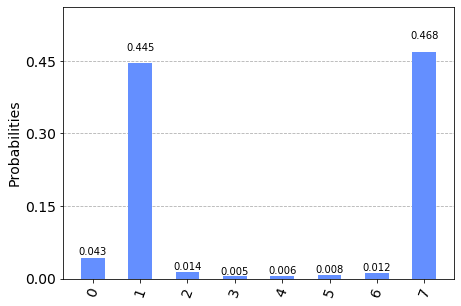

In [130]:
plot_histogram(accumulated)

In [131]:
np.sin(np.pi * most_likely / 2 ** num_eval_qubits) ** 2

0.1464466094067263

In [132]:
print([np.sin(np.pi * i / 2 ** num_eval_qubits) ** 2 for i in range(2 ** (num_eval_qubits - 1) + 1)])

[0.0, 0.14644660940672624, 0.4999999999999999, 0.8535533905932737, 1.0]
